In [1]:
import igraph
import xml.etree.ElementTree as ElementTree
import numpy as np
from tqdm.notebook import tqdm

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
mappings = ('ala:A|arg:R|asn:N|asp:D|cys:C|gln:Q|glu:E|gly:G|his:H|ile:I|leu:L|lys:K|met:M|phe:F|pro:P|ser:S|thr:T|trp:W|tyr:Y|val:V').upper().split('|')
letter2aa = dict([m.split(':')[::-1] for m in mappings])

In [3]:
with open('proteins/6ct4.fasta') as file:
    fasta = file.read().strip().split('\n')[-1]
print('protein fasta:', fasta)
res_sequence = fasta

forcefield = ElementTree.parse('forcefields/amber99sb.xml').getroot()

atoms = []
bonds = []
external_bond_indices = []
for i, res in enumerate(res_sequence):
    external_bond_indices.append([])
    atom_count = len(atoms)

    aa_name = letter2aa[res]
    if i == 0:
        aa_name = 'N' + aa_name
    elif i == len(res_sequence) - 1:
        aa_name = 'C' + aa_name

    for obj in forcefield.find(f'Residues/Residue[@name=\'{aa_name}\']'):
        if obj.tag == 'Atom':
            name = obj.get('name')
            type_id = int(obj.get('type'))

            atom_traits = forcefield[0][type_id].attrib
            atom_class = atom_traits['class']
            element = atom_traits['element']
            mass = float(atom_traits['mass'])

            nonbonded_traits = forcefield[5][type_id].attrib
            charge = float(nonbonded_traits.get('charge'))
            sigma = float(nonbonded_traits.get('sigma'))
            epsilon = float(nonbonded_traits.get('epsilon'))

            pos = np.random.uniform(size=3)
            atoms.append(dict(name=name, type_id=type_id, atom_class=atom_class, element=element,
                                  residue=aa_name, mass=mass, charge=charge, sigma=sigma, epsilon=epsilon, pos=pos))
        elif obj.tag == 'Bond':
            from_index = atom_count + int(obj.get('from'))
            to_index = atom_count + int(obj.get('to'))

            from_atom = atoms[from_index]
            to_atom = atoms[to_index]

            bond = forcefield.find(f'HarmonicBondForce/Bond[@class1=\'{from_atom["atom_class"]}\'][@class2=\'{to_atom["atom_class"]}\']')
            if bond is None:
                bond = forcefield.find(f'HarmonicBondForce/Bond[@class1=\'{to_atom["atom_class"]}\'][@class2=\'{from_atom["atom_class"]}\']')

            bonds.append(dict(from_index=from_index, to_index=to_index,
                              length=float(bond.get('length')), k=float(bond.get('k')), bond_type='internal'))
        elif obj.tag == 'ExternalBond':
            from_index = atom_count + int(obj.get('from'))
            external_bond_indices[-1].append(dict(from_index=from_index))
        else:
            print(f'Unsupported type {obj.type}')
           
    if i > 0:
        from_index = external_bond_indices[i-1][-1]['from_index']
        to_index = external_bond_indices[i][0]['from_index']

        from_atom = atoms[from_index]
        to_atom = atoms[to_index]
        
        bond = forcefield.find(f'HarmonicBondForce/Bond[@class1=\'{from_atom["atom_class"]}\'][@class2=\'{to_atom["atom_class"]}\']')
        if bond is None:
            bond = forcefield.find(f'HarmonicBondForce/Bond[@class1=\'{to_atom["atom_class"]}\'][@class2=\'{from_atom["atom_class"]}\']')
        bonds.append(dict(from_index=from_index, to_index=to_index, length=float(bond.get('length')),
                          k=float(bond.get('k')), bond_type='external'))
print(f'finished parsing {len(res_sequence)} residues with {len(atoms)} atoms and {len(bonds)} bonds')

protein fasta: PMKKLKLALRLAAKIAPVW
finished parsing 19 residues with 335 atoms and 338 bonds


In [4]:
graph = igraph.Graph()
for atom in atoms:
    v = graph.add_vertex(atom['name'])
    v.update_attributes(atom)
for bond in bonds:
    e = graph.add_edge(graph.vs[bond['from_index']], graph.vs[bond['to_index']])
    e.update_attributes(bond)
print(graph)

IGRAPH UN-- 335 338 --
+ attr: atom_class (v), charge (v), element (v), epsilon (v), mass (v), name
  (v), pos (v), residue (v), sigma (v), type_id (v), bond_type (e), from_index
  (e), k (e), length (e), to_index (e)
+ edges (vertex names):
N--H2, N--H3, N--CD, N--CA, CD--HD2, CD--HD3, CD--CG, CG--HG2, CG--HG3,
CG--CB, CB--HB2, CB--HB3, CB--CA, CA--HA, CA--C, C--O, N--H, N--CA, CA--HA,
CA--CB, CA--C, CB--HB2, CB--HB3, CB--CG, CG--HG2, CG--HG3, CG--SD, SD--CE,
CE--HE1, CE--HE2, CE--HE3, C--O, C--N, N--H, N--CA, CA--HA, CA--CB, CA--C,
CB--HB2, CB--HB3, CB--CG, CG--HG2, CG--HG3, CG--CD, CD--HD2, CD--HD3, CD--CE,
CE--HE2, CE--HE3, CE--NZ, NZ--HZ1, NZ--HZ2, NZ--HZ3, C--O, C--N, N--H, N--CA,
CA--HA, CA--CB, CA--C, CB--HB2, CB--HB3, CB--CG, CG--HG2, CG--HG3, CG--CD,
CD--HD2, CD--HD3, CD--CE, CE--HE2, CE--HE3, CE--NZ, NZ--HZ1, NZ--HZ2, NZ--HZ3,
C--O, C--N, N--H, N--CA, CA--HA, CA--CB, CA--C, CB--HB2, CB--HB3, CB--CG,
CG--HG, CG--CD1, CG--CD2, CD1--HD11, CD1--HD12, CD1--HD13, CD2--HD21,
CD2--H

In [5]:
def bfs(graph, vid, max_dist=None):
    order, parents = [], []
    for v, dist, parent in graph.bfsiter(vid, advanced=True):
        if max_dist is not None and dist > max_dist:
            break
        order.append(v.index)
        parents.append(parent.index if parent is not None else -1)
    return (order, parents)

def remove_bfs_vertex(vid, order, parents, n=0):
    if vid in order:
        order[np.argwhere(order == vid)[0,0]] = -1
    for index in np.argwhere(parents == vid):
        remove_bfs_vertex(order[index], order, parents, n=n+1)

max_dist = None    
for e in graph.es:
    result = bfs(graph, e.source, max_dist=max_dist)
    order, parents = np.array(result[0]), np.array(result[1])
    remove_bfs_vertex(e.target, order, parents)
    e.update_attributes(source_influence=list(order[order != -1]))
    
    result = bfs(graph, e.target, max_dist=max_dist)
    order, parents = np.array(result[0]), np.array(result[1])
    remove_bfs_vertex(e.source, order, parents)
    e.update_attributes(target_influence=list(order[order != -1]))

In [6]:
step_size = 1
steps = 10

t = tqdm(total=steps, unit='step')
for step in range(steps):
    total_error = 0
    #offsets = np.random.normal(0, 0.5, size=(len(graph.vs), 3))
    offsets = np.zeros((len(graph.vs), 3))
    for e in graph.es:
        vec = e.target_vertex['pos'] - e.source_vertex['pos']
        dist = np.linalg.norm(vec)
        error = dist - e['length']
        total_error += error
        for v in e['source_influence']:
            offsets[v] += vec / dist * error / 2
        for v in e['target_influence']:
            offsets[v] -= vec / dist * error / 2
    total_error /= len(graph.es)

    for v, offset in zip(graph.vs, offsets):
        v['pos'] += offset * step_size
    
    status = dict(total_error=f'{total_error:.3g}')
    t.set_postfix(status)
    t.update()

<IPython.core.display.Javascript object>


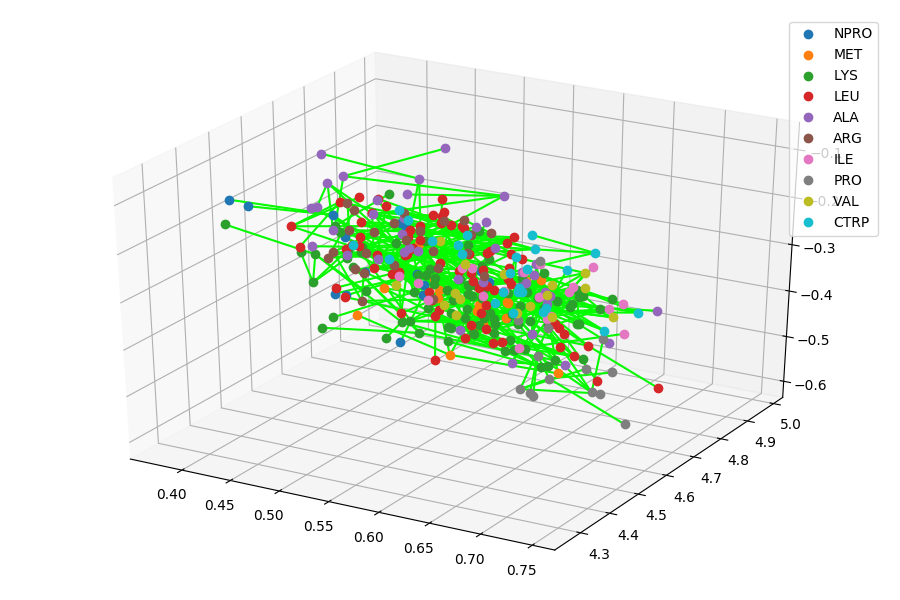

In [7]:
def draw_graph(g):
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')

    for edge in g.es:
        pos1 = edge.source_vertex['pos']
        pos2 = edge.target_vertex['pos']
        error = np.minimum(1, np.abs(np.linalg.norm(pos2 - pos1) - e['length']))
        ax.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], [pos1[2], pos2[2]], c=(error, (1 - error), 0))

    vertex_dict = {}
    for vertex in g.vs:
        if vertex['residue'] in vertex_dict:
            vertex_dict[vertex['residue']].append(vertex)
        else:
            vertex_dict[vertex['residue']] = [vertex]
            
    for res, vertices in vertex_dict.items():
        pos = np.array([vertex['pos'] for vertex in vertices])
        ax.plot(pos[:,0], pos[:,1], pos[:,2], 'o', label=res)
        
    plt.legend()
    plt.tight_layout()
    plt.show()
    
draw_graph(graph)